### 1) Imports

In [1]:
import os
import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb
from scipy.spatial import ConvexHull
import scipy.spatial.distance as scidist

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import tqdm


### 2) Defining global stuff

In [2]:
DISTANCE = 10
DENSITY = 22
HYDROPHOBICS = ['LEU', 'ILE', 'PHE', 'TYR', 'TRP', 'CYS', 'MET']

### 3) Funtions

In [3]:
def doMining(pdb, atomTable):
    """
    This function find all features of interest (data mining) and returns a table with the given features
    """
    
    # Matrix for all atoms
    m = atomTable[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # Compute convex hull
    hull = ConvexHull(m, qhull_options="Q1")

    # Compute distances
    distvector = scidist.pdist(m)
    dist = scidist.squareform(distvector)

    # Var's
    protrusions = []
    atomNames = atomTable["atom_name"].to_numpy()
    
    # Find protrusions
    for idx, row in enumerate(dist):
        # Atom has to be a convex hull vertex
        if idx in hull.vertices:
            # Atom has to be CB
            if atomNames[idx] == "CB":
                # Check low density
                if row[row < DISTANCE].shape[0] - 1 < DENSITY:
                    protrusions.append(idx)

    # Find hydrophobic protrusions
    tmp = atomTable.loc[protrusions]
    hydrophobic_protrusions = tmp[tmp["residue_name"].isin(HYDROPHOBICS)].index.tolist()

    # Build & return data of interest
    hp = atomTable.loc[hydrophobic_protrusions]
    return pd.DataFrame({"pdb": pdb,
                         "number_of_protrusions": len(protrusions),
                         "number_of_hydrophobic_protrusions": len(hydrophobic_protrusions),
                         "atom_indices_of_hydrophobic_protrusions": ", ".join(
                             [str(x) for x in hp["index"].tolist()]),
                         "residue_names_of_hydrophobic_protrusions": ", ".join(
                             [str(x) for x in hp["residue_name"].tolist()])
                         }, index=[0])


def protrusion_mining(pdb, atomTable):
    
    # Matrix for all atoms
    m = atomTable[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # Compute convex hull
    hull = ConvexHull(m)

    # Compute distances
    distvector = scidist.pdist(m)
    dist = scidist.squareform(distvector)

    # Var's
    protrusions = pd.DataFrame()
    atomNames = atomTable["atom_name"].to_numpy()
    
    # Find protrusions
    for idx, row in enumerate(dist):
        
        # Atom has to be CB
        if atomNames[idx] == "CB":
            
            # Tmp Var's
            onConvHull = 0
            neighbours = row[row < DISTANCE].shape[0] - 1
            isprotrusion = 0
        
            # Atom has to be a convex hull vertex
            if idx in hull.vertices:
                onConvHull = 1
            
                # Check low density
                if neighbours < DENSITY:
                    isprotrusion = 1
            
            # Collect data
            smpl = pd.DataFrame({"pdb": pdb,
                                 "residue_number": atomTable.iloc[idx,]["residue_number"],
                                 "residue_name": atomTable.iloc[idx,]["residue_name"],
                                 "atom_number": atomTable.iloc[idx,]["atom_number"],
                                 "atom_name": atomTable.iloc[idx,]["atom_name"],
                                 "is_on_convhull": onConvHull,
                                 "neighbours": neighbours,
                                 "is_protrusion": isprotrusion
                                }, index=[0])
            protrusions = protrusions.append(smpl, ignore_index=True)
    
    # Return     
    return protrusions
    


def extract_atom_table(path):
    """
    This function extracts the atom table of a given pdb, returns just rows of CA and CB.
    :param path: Path to the pdb file
    :return: pandas.core.frame.DataFrame, containing every CA and CB atom for this pdb
    """
    pdb = PandasPdb().read_pdb(path)
    atomTable = pdb.df["ATOM"]
    return atomTable


def trim_and_filter_data(atomTable):
    """
    This function trims & filters the atomTable for some properties and returns the final atomTable
    """
     # Trim for multiple structures
    #atomTable = atomTable[0:atomTable.iloc[-1]["atom_number"]]
    
    # Subset only CA & CB atoms
    atomTable = atomTable.query("atom_name in ['CA', 'CB']")
    
    # Trim for multiple alternate locations
    atomTable = atomTable.query("alt_loc in ['A', '']")
    
    # Trim for multiple chains
    #atomTable = atomTable[atomTable["chain_id"] == atomTable["chain_id"].unique()[0]]
    
    # Trim glycin that does not have cb
    #atomTable = atomTable.query("residue_name != 'GLY'")
    
    # return
    return atomTable.reset_index()


def readIDs(filepath):
    """
    Read / parse a text file containing pdb ID's

    :param filepath: The path to the file to parse / read
    :return: The list of pdb ID's parsed
    """
    id_list = []
    with open(filepath) as f:
        for line in f:
            id_list.append(line.replace("\n", ""))

    return id_list

<br>

### 4) Read data & build dataset

4.1) Read everything into memory for faster access

In [7]:
periph = readIDs("../periph_ids.csv")
periph_tables = []

for pdb in tqdm.tqdm(periph):
    periph_tables.append(extract_atom_table("../opm_data/periph/" + pdb + ".pdb"))

100%|██████████| 1012/1012 [02:01<00:00,  8.30it/s]


<br>

4.2) Build dataset

In [8]:
# Filtering
periph_tables_filtered = []
for atomTable in tqdm.tqdm(periph_tables):
    periph_tables_filtered.append(trim_and_filter_data(atomTable))

100%|██████████| 1012/1012 [00:09<00:00, 107.02it/s]


In [9]:
# Building
data_periph = pd.DataFrame()
for idx, atomTable in enumerate(tqdm.tqdm(periph_tables_filtered)):
    data_periph = data_periph.append(doMining(periph[idx], atomTable), ignore_index=True)

100%|██████████| 1012/1012 [00:16<00:00, 60.21it/s]


<br>
4.3) Save dataset

In [41]:
data_periph.to_csv("basicFeatures_periph.csv", sep="\t", encoding="utf-8")

<br>

### 5) Analysis

In [42]:
result_periph = pd.read_csv("basicFeatures_periph.csv", sep="\t")
result_periph_edvin = pd.read_csv("edvinsProtrusionData_periph.csv", sep=",")
result_periph_edvin.columns = ["idx", "edv_number_of_hydrophobic_protrusions", "edv_number_of_protrusions", "edv_pdb"]

In [43]:
data = pd.concat([result_periph_edvin, result_periph[["number_of_hydrophobic_protrusions", "number_of_protrusions", "pdb"]]], axis=1)

In [20]:
atomTable = extract_atom_table("pdb_data/periph/" + "3biw" + ".pdb")
doMining("3biw", atomTable)

atom_indices_of_hydrophobic_protrusions  number_of_hydrophobic_protrusions  \
0                                                                          0   

   number_of_protrusions   pdb residue_names_of_hydrophobic_protrusions  
0                     43  3biw

In [28]:
data.to_csv("num_of_protrusions_betw_edvin_and_florian_full.csv", sep="\t", encoding="utf-8")

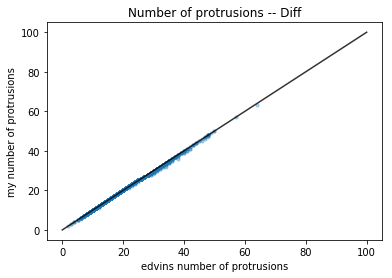

In [44]:
fig, ax = plt.subplots()

line = mlines.Line2D([0,100], [0,100], color="black", alpha=0.8)
ax.add_line(line)

#data2 = data.loc[data['edv_number_of_protrusions'] != data['number_of_protrusions']]
data2 = data
ax.scatter(data2.iloc[:,2], data2.iloc[:,5], alpha=0.3, s=10)

plt.title("Number of protrusions -- Diff")
plt.xlabel("edvins number of protrusions")
plt.ylabel("my number of protrusions")

#plt.ylim(10,30)
#plt.xlim(10,30)

# plt.axis("scaled")
# plt.show()
plt.savefig("num_of_protrusions_diff_tmp.png", dpi=1200)

In [45]:
data.loc[data['edv_number_of_protrusions'] != data['number_of_protrusions']]

idx  edv_number_of_hydrophobic_protrusions  edv_number_of_protrusions  \
23      24                                    8.0                         38   
39      40                                    4.0                         24   
83      84                                    3.0                         30   
141    142                                    1.0                         34   
150    151                                    2.0                         34   
211    212                                    6.0                         25   
214    215                                   10.0                         48   
251    252                                    1.0                         36   
259    260                                    3.0                         35   
301    302                                    3.0                         42   
359    360                                    7.0                         38   
368    369                                    4.0                         31   
418    419                                    4.0                         35   
432    433                                    8.0                         33   
440    441                                    3.0                         24   
441    442                                    3.0                         41   
479    480                                    5.0                         22   
560    561                                    4.0                         36   
587    588                                    2.0                         12   
714    715                                    6.0                         64   
737    738                                    2.0                         35   
750    751                                    2.0                         32   
771    772                                    2.0                         31   
809    810                                    2.0                         47   
838    839                                    1.0                         30   
851    852                                    3.0                         46   
856    857                                    3.0                         32   
862    863                                    1.0                         34   
871    872                                    3.0                         41   
929    930                                    3.0                         40   
956    957                                    3.0                         23   
967    968                                    3.0                         29   
975    976                                   10.0                         42   
996    997                                    2.0                         30   
1006  1007                                    3.0                         29   
1007  1008                                    3.0                         40   
1009  1010                                    2.0                         33   

     edv_pdb  number_of_hydrophobic_protrusions  number_of_protrusions   pdb  
23      3j2s                                  8                     37  3j2s  
39      1rgx                                  4                     23  1rgx  
83      1b9x                                  2                     29  1b9x  
141     3bl8                                  1                     33  3bl8  
150     3myv                                  2                     32  3myv  
211     1ocu                                  6                     24  1ocu  
214     2brj                                 10                     47  2brj  
251     1rrh                                  1                     35  1rrh  
259     1hh4                                  3                     34  1hh4  
301     3dy5                                  3                     41  3dy5  
359     3w15                                  6                     36  3w15  
368     1cx2      

In [162]:
data2["diff"] = list(abs(data2["edv_number_of_protrusions"] - data2["number_of_protrusions"]))
#data2.loc[data['edv_number_of_protrusions'] != data['number_of_protrusions']]
data2.query("pdb == '3myv'")

idx  edv_number_of_hydrophobic_protrusions  edv_number_of_protrusions  \
150  151                                    2.0                         34   

    edv_pdb  number_of_hydrophobic_protrusions  number_of_protrusions   pdb  \
150    3myv                                  2                     32  3myv   

     diff  
150     2

In [46]:
len(data2.loc[data['edv_number_of_protrusions'] != data['number_of_protrusions']])

37

In [7]:
edv_stuff = pd.read_csv("edvin_datasets_protrusions/protrusions_periph2.csv", sep=",")

<br>

### -- Analysis of what is different --

In [47]:
pdb = "3j2s"

idx = periph.index(pdb)
atomTable = periph_tables_filtered[idx]
stuff = protrusion_mining(pdb, atomTable)

t1 = edv_stuff.query("structure == '" + pdb + "' & convhull > 0 & neighbours < 22")
t2 = stuff.query("is_on_convhull > 0 & neighbours < 22")

diff = np.setdiff1d(np.sort(t1["resid"].to_numpy().astype(np.int)), t2["residue_number"].to_numpy())

print "Edvins number of protrusion: ", len(t1)
print "My number of protrusions: ", len(t2)
print "Residues that are different: ", diff

Edvins number of protrusion:  38
My number of protrusions:  37
Residues that are different:  [2184]


In [48]:
stuff.query("residue_number in " + str(diff))

atom_name  atom_number  is_on_convhull  is_protrusion  neighbours   pdb  \
450        CB         3928               0              0          19  3j2s   

    residue_name  residue_number  
450          ALA            2184

In [49]:
s = '[' + "'" + str(diff[0]) + "'"
for i in diff[1:len(diff)]:
    s += "," + "'" + str(i) + "'"
s += ']'
edv_stuff.query("structure == '" + pdb + "' & resid in " + s)

facet_neighbours_polar resid chain  exposed  clusterness  \
4017                      0  2184     B        1     0.783626   

     facet_neighbours_ww_if  neighbours facet_neighbours   sc_assa  \
4017                      0          19                0  0.379139   

     facet_neighbours_ww_oct  insertion  convhull       y       x       z  \
4017                       0    -2.5467         1  1.2275  0.0366  4.0867   

     type structure  
4017  ALA      3j2s

In [192]:
pdb = "3j2s"
atomTable = extract_atom_table("opm_data/periph/3j2s.pdb")
atomTable["x_coord"] = atomTable["x_coord"] / 10.0
atomTable["y_coord"] = atomTable["y_coord"] / 10.0
atomTable["z_coord"] = atomTable["z_coord"] / 10.0
atomTable = trim_and_filter_data(atomTable)

# Matrix for all atoms
m = atomTable[["x_coord", "y_coord", "z_coord"]].to_numpy()

# Compute convex hull
hull = ConvexHull(m)

# Compute distances
distvector = scidist.pdist(m)
dist = scidist.squareform(distvector)

# Var's
protrusions = []
atomNames = atomTable["atom_name"].to_numpy()

# Find protrusions
for idx, row in enumerate(dist):
    
    # Atom has to be a convex hull vertex
    if idx in hull.vertices:
        
        # Atom has to be CB
        if atomNames[idx] == "CB":
            
            #print row[row < 1.5].shape[0] - 1
            
            # Check low density
            if row[row < 1].shape[0] - 1 < DENSITY:
                protrusions.append(idx)

In [193]:
len(protrusions)

37

In [10]:
atomTable

index record_name  atom_number blank_1 atom_name alt_loc residue_name  \
0        1        ATOM            2                CA                  ILE   
1        4        ATOM            5                CB                  ILE   
2        6        ATOM            7                CA                  CYS   
3        9        ATOM           10                CB                  CYS   
4       12        ATOM           13                CA                  SER   
5       15        ATOM           16                CB                  SER   
6       18        ATOM           19                CA                  ALA   
7       21        ATOM           22                CB                  ALA   
8       23        ATOM           24                CA                  ARG   
9       26        ATOM           27                CB                  ARG   
10      28        ATOM           29                CA                  ALA   
11      31        ATOM           32                CB                  ALA   
12      33        ATOM           34                CA                  PRO   
13      36        ATOM           37                CB                  PRO   
14      40        ATOM           41                CA                  ALA   
15      43        ATOM           44                CB                  ALA   
16      45        ATOM           46                CA                  LYS   
17      48        ATOM           49                CB                  LYS   
18      54        ATOM           55                CA                  TYR   
19      57        ATOM           58                CB                  TYR   
20      66        ATOM           67                CA                  SER   
21      69        ATOM           70                CB                  SER   
22      72        ATOM           73                CA                  ILE   
23      75        ATOM           76                CB                  ILE   
24      80        ATOM           81                CA                  THR   
25      83        ATOM           84                CB                  THR   
26      87        ATOM           88                CA                  PHE   
27      90        ATOM           91                CB                  PHE   
28      98        ATOM           99                CA                  THR   
29     101        ATOM          102                CB                  THR   
..     ...         ...          ...     ...       ...     ...          ...   
381   1527        ATOM         1528                CA                  LEU   
382   1530        ATOM         1531                CB                  LEU   
383   1535        ATOM         1536                CA                  LYS   
384   1538        ATOM         1539                CB                  LYS   
385   1540        ATOM         1541                CA                  ALA   
386   1543        ATOM         1544                CB                  ALA   
387   1545        ATOM         1546                CA                  LEU   
388   1548        ATOM         1549                CB                  LEU   
389   1553        ATOM         1554                CA                  PRO   
390   1556        ATOM         1557                CB                  PRO   
391   1560        ATOM         1561                CA                  PRO   
392   1563        ATOM         1564                CB                  PRO   
393   1567        ATOM         1568                CA                  ILE   
394   1570        ATOM         1571                CB                  ILE   
395   1575        ATOM         1576                CA                  ALA   
396   1578        ATOM         1579                CB                  ALA   
397   1580        ATOM         1581                CA                  ARG   
398   1583        ATOM         1584                CB                  ARG   
399   1591        ATOM         1592                CA                  VAL   
400   1594        ATOM     

In [ ]:
data2["diff"].value_counts().plot(kind="bar")
plt.savefig("diff_tmp.png", dpi=1200)